# Understanding the Amazon rainforest from space

## Overview of Section
1. Split of test data/training data Justification
2. Weather models (Multi-classifier single labels)
3. Single Label Land Approach
4. Multi-label land approach
5. Combined Land/Weather approach


Given we are mostly interested in being able to tell where deforestation is occuring, we will simplify the land tags into naturally occuring phenomena 



In [2]:
import numpy as np # linear algebra
import pandas as pd 
from subprocess import check_output
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import scipy.stats
import seaborn as sns

import random
import math
from skimage import io
import itertools
from sklearn import preprocessing

from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from skimage import transform
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.multioutput import ClassifierChain
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support as score
import warnings
warnings.filterwarnings('ignore')

C:\Users\Elle\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Elle\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## 1. Split of test training data
We are choosing to split the data 90 to 10 training to test. This is because we want to keep as much information for learning as possible while still retaining a reasonable sample size >2000 for testing.

We will also scale the data, to ensure that no feature is overweighted.

In [4]:
#obtain processed training labels and data
labels = pd.read_csv('train_labels_clean.csv')

data = pd.read_csv('train_data.csv')
## sclae the data so nothing is dominating
min_max_scaler = preprocessing.MinMaxScaler()
data_minmax = min_max_scaler.fit_transform(data)



# Create training and test sets for weather labels by randomly splitting the original dataset as 90%/10%
train_data_weather, test_data_weather, train_labels_weather, test_labels_weather = train_test_split(data_minmax, labels.weather, test_size=0.1)
# Create training and test sets for land labels by randomly splitting the original dataset as 90%/10%
train_data_land, test_data_land, train_labels_land, test_labels_land = train_test_split(data_minmax, labels.land, test_size=0.1)
# Create training and test sets for multi-label land labels by randomly splitting the original dataset as 90%/10%
labels['tags_split'] = labels['land'].map(lambda row: row.split(" "))
mlb = MultiLabelBinarizer()
multi_labels_land = mlb.fit_transform(labels['tags_split'])
multi_labels_combined = mlb.fit_transform(labels['tags_split'])
train_data_land_multi, test_data_land_multi, train_labels_land_multi, test_labels_land_multi= train_test_split(data_minmax, multi_labels_land, test_size=0.1)
train_data_combined, test_data_land_combined, train_labels_combined, test_labels_combined= train_test_split(data_minmax, multi_labels_combined, test_size=0.1)

## Weather feature identification

Weather feature identification is being performed for cloud and haze removal. This facilitates the successive water, land and primary feature identification.

1. Create Useful fucntions
2. Try a variety of models
3. Improve on the most successful model preformance

 ## 1. Output Functions
 

In [24]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def single_model_output(pipeline, scores, train_data, train_label, test_data, test_label):
    pipeline.fit(train_data,train_label)
    model_predictions=pipeline.predict(test_data)

    print("Cross-Validation\n Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2)) 

    con_fu=confusion_matrix(test_label, model_predictions)
    class_list=sorted(list(set(test_label)))
    return plot_confusion_matrix(con_fu, classes=class_list)

def multiple_model_output(pipeline, scores, train_data, train_label, test_data, test_label):
    pipeline.fit(train_data,train_label)
    model_predictions=pipeline.predict(test_data)
    
    print("Cross-Validation\n Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2)) 
    
    return classification_report(test_label,model_predictions)

## 2. Logistic Regression

In [6]:
# Setup the pipeline for logistics regression
LG_model =LogisticRegression(tol=0.02)
LG_pipeline = Pipeline([
    ('LogisticsRegression', LG_model),
])

LG_scores = cross_val_score(LG_pipeline,
                            train_data_weather,
                            train_labels_weather,
                            cv=10,
                            scoring='f1_micro')

Cross-Validation
 Accuracy: 0.88 (+/- 0.01)


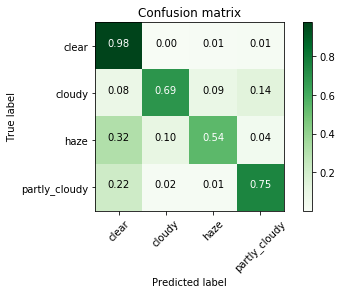

In [7]:
# Check output for Logistics Regression
single_model_output(LG_pipeline, LG_scores, train_data_weather, train_labels_weather, test_data_weather, test_labels_weather)

This model works okay for clear weather - but not really for anything else, we can see it's biasing the result toward the biggest sample, though interestingly it confuses cloudy for everything else. Log Reg probably not the way to go. So we won't spend too much time playing with the paramaters of the model.


In [12]:
# Setup the pipeline for decision tree. Use GridSearchCV to find the best depth for decision tree
param_grid = dict(DecisionTrees__max_depth=[5,10,20,50,100], DecisionTrees__min_samples_leaf=[2,5,10,15,20,25])
DT_model=DecisionTreeClassifier()
DT_pipeline = Pipeline([
    ('DecisionTrees', DT_model),
])

grid_tree = GridSearchCV(DT_pipeline, param_grid)
grid_tree.fit(train_data_weather, train_labels_weather)
tree_preds = grid_tree.predict(test_data_weather)

In [13]:
print("The best tree parameters are: " + str(grid_tree.best_params_))

The best tree parameters are: {'DecisionTrees__max_depth': 100, 'DecisionTrees__min_samples_leaf': 20}


In [14]:
# Set up the pipeline for decision tree with the best depth = 100, samples =20
DT_model_best =DecisionTreeClassifier(min_samples_leaf=20, max_depth=100)
DT_pipeline_best = Pipeline([
    ('DecisionTrees', DT_model_best),
])

DT_scores = cross_val_score(DT_pipeline_best,
                            train_data_weather,
                            train_labels_weather,
                            cv=10,
                            scoring='f1_micro')

Cross-Validation
 Accuracy: 0.87 (+/- 0.01)


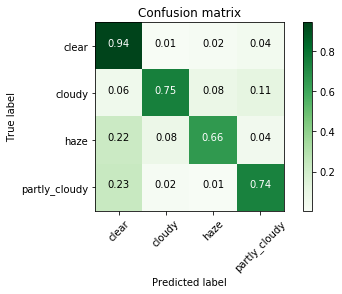

In [28]:
# Check output for Decision Tree
single_model_output(DT_pipeline_best, DT_scores, train_data_weather, train_labels_weather, test_data_weather, test_labels_weather)

Even though the cross-validation score is lower - we could prefer this model to Logistic Regression because it does better with the rare labels. 

We can see that it improves the predictions on both cloudy and haze but it makes partly cloudly slightly worse.

In [20]:
# Setup the pipeline for random forest. Use GridSearchCV to find the best parameters 
param_grid = dict(RandomForest__max_depth=[20,50,75],
                 RandomForest__n_estimators = [20,50,100],
                 RandomForest__min_samples_leaf = [5,10,20])

RF_model =RandomForestClassifier()
RF_pipeline = Pipeline([
    ('RandomForest', RF_model),
])

grid_forest = GridSearchCV(RF_pipeline, param_grid)
grid_forest.fit(train_data_weather, train_labels_weather)
forest_preds = grid_forest.predict(test_data_weather)

In [21]:
print("The best tree parameters are: " + str(grid_forest.best_params_))

The best tree parameters are: {'RandomForest__max_depth': 50, 'RandomForest__min_samples_leaf': 5, 'RandomForest__n_estimators': 100}


In [26]:
# Set up the pipeline for random forest with the best parameters
RF_model_best =RandomForestClassifier(n_estimators=100, min_samples_leaf=5,max_depth=50)
RF_pipeline_best = Pipeline([
    ('RandomForest', RF_model_best),
])

RF_scores = cross_val_score(RF_pipeline_best, 
                                          train_data_weather,
                                          train_labels_weather, 
                                          cv=10,
                                          scoring='f1_micro')

Cross-Validation
 Accuracy: 0.90 (+/- 0.01)


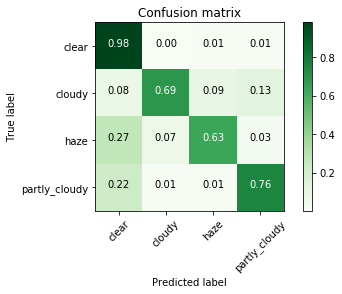

In [27]:
# Check output for Random Forest
single_model_output(RF_pipeline_best, RF_scores, train_data_weather, train_labels_weather, test_data_weather, test_labels_weather)

This is now a fairly accurate model for the clear and partly cloudy models. Hazy is still getting confused with primary and clouds are getting confused for everything. We saw from our EDA - that quite a lot of the clear pictures appear hazy so perhaps this is why. We'll examine some of the hazt pictures to see why they're getting them so wrong.

We note that this would be our preferred model due to the relatively high cross validation score and that the images. Let's look at why it's predicting the haze tagg quite so pporly.

## 2. Land Models - single label models

In [ ]:
# Setup the pipeline for random forest. Use GridSearchCV to find the best parameters 
param_grid = dict(RandomForest__max_depth=[5, 10,20,50,75],
                 RandomForest__n_estimators = [20,50,100,200],
                 RandomForest__min_samples_leaf = [2,3,4,5,10])
RF_model_land =RandomForestClassifier()
RF_pipeline_land = Pipeline([
    ('RandomForest', RF_model_land),
])

grid_forest_land = GridSearchCV(RF_pipeline_land, param_grid)
grid_forest_land.fit(train_data_land, train_label_land)
forest_preds_land = grid_forest_land.predict(test_data_land)

In [ ]:
print("The best tree depth is: " + str(grid_forest_land.best_params_))

In [ ]:
# Set up the pipeline for random forest with the best parameters
RF_model_land_best =RandomForestClassifier(n_estimators=100, min_samples_leaf=2,max_depth=10)
RF_pipeline_land_best = Pipeline([
    ('RandomForest', RF_model_land_best),
])

RF_land_scores = cross_val_score(RF_pipeline_land_best, 
                                          train_data_land,
                                          train_labels_land, 
                                          cv=10,
                                          scoring='f1_micro')

In [ ]:
# Check output for Random Forest
single_model_output(RF_pipeline_land_best, RF_land_scores, train_data_land, train_labels_land, test_data_land, test_labels_land)

The model does extremely badly on picking up models with water - it is fairly efficient at picking up primary and primary tags vs other, but basically nothing else. 

This is clearly not a good model, as by forcing the labels to separate we lose all the predictive power contained in other labels. I.e. what's in a primary water image, will hopefully help use to predict whats in a water other tag as well.

# Multi-label models

In [22]:
#GridSearchCV function for One vs. Rest (OVR) models
def multi_gridsearchcv(param_grid, model, train_data, train_labels, test_data):
    model_tuning=GridSearchCV(model, param_grid)
    model_tuning.fit(train_data, train_labels)
    print("The best parameters for the model are : " +str(model_tuning.best_params_))

In [23]:
#Pipeline for OVR models
def multi_pipeline(model, estimator, train_data, train_labels, test_data, test_labels, scoring='f1_micro', cv=10):
    multi_pipe = Pipeline([
        (estimator,model),
    ])
    multi_scores = cross_val_score(multi_pipe, 
                                 train_data,
                                 train_labels,
                                 scoring=scoring,
                                 cv=cv
                                )
    
    multiple_model_output(multi_pipe, multi_scores, train_data, train_labels, test_data, test_labels)

### One vs. Rest

#### OVR-Random Forest

In [5]:
#Run GridSearchCV for OVR model with Random Forest Estimator

#Parameter grid for final draft
'''param_grid = {'estimator__max_depth':[5,10,20,50,75], 
              'estimator__n_estimators':[20,50,100,200],
              'estimator__min_samples_leaf':[2,3,4,5,10]}'''

multi_gridsearchcv(param_grid= {'estimator__max_depth':[5,10],
                                  'estimator__n_estimators':[20,50],
                                  'estimator__min_samples_leaf':[2,3]},
                 model = OneVsRestClassifier(RandomForestClassifier()),
                 train_data=train_data_land_multi,
                 train_labels=train_labels_land_multi,
                 test_data=test_data_land_multi
                )

The best parameters for the model are : {'estimator__max_depth': 10, 'estimator__min_samples_leaf': 3, 'estimator__n_estimators': 50}


             precision    recall  f1-score   support

          0       0.85      0.68      0.76       219
          1       0.82      0.81      0.82      1553
          2       0.97      0.99      0.98      3744
          3       0.87      0.59      0.70       750

avg / total       0.92      0.89      0.90      6266

Cross-Validation
 Accuracy: 0.90 (+/- 0.00)


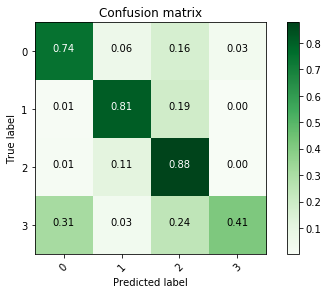

In [8]:
#Get classification report and confusion matrix for OVR model with Random Forest Estimator
multi_pipeline(model=OneVsRestClassifier(RandomForestClassifier(n_estimators=100, min_samples_leaf=2,max_depth=10)),
             estimator='RandomForest',
             train_data=train_data_land_multi,
             train_labels=train_labels_land_multi,
             test_data=test_data_land_multi,
             test_labels=test_labels_land_multi
            )

We can see that model is now predicting water reasonably well, and the none tag about as well as the weather model was. 

The most important thing is that ti's getting the forest tag right with high recall and precision, so we know when and 

It's also predicting the other tag well - which is impressive when we consider how many different types of information can be contained at other.

With the way we've reduce the size of the photo we may be just losing too much of the information about water to be able to predict it.

#### OVR-Decision Tree

In [ ]:
#Run GridSearchCV for OVR model with Decision Tree Estimator
'''param_grid = {'estimator__max_depth':[5,10,20,50,75],
              'estimator__min_samples_leaf':[2,3,4,5,10]}'''

multi_gridsearchcv(param_grid= {'estimator__max_depth':[50,75],
                              'estimator__min_samples_leaf':[5,10]},
                 model = OneVsRestClassifier(DecisionTreeClassifier()),
                 train_data=train_data_land_multi,
                 train_labels=train_labels_land_multi,
                 test_data=test_data_land_multi
                )

In [ ]:
#Get classification report and confusion matrix for OVR model with Decision Tree Estimator
multi_pipeline(model=OneVsRestClassifier(DecisionTreeClassifier(max_depth=50, min_samples_leaf=10)),
             estimator='DecisionTrees',
             train_data=train_data_land_multi,
             train_labels=train_labels_land_multi,
             test_data=test_data_land_multi,
             test_labels=test_labels_land_multi
            )

In [ ]:
WE can see the one vs rest classifier for decision tree is slightly outperformed t

### Classifier Chains

#### Classifier Chains-Random Forest

In [ ]:
#Run GridSearchCV for Classifier Chain Model with Random Forest estimator
'''param_grid = {'estimator__max_depth':[5,10,20,50,75], 
              'estimator__n_estimators':[20,50,100,200],
              'estimator__min_samples_leaf':[2,3,4,5,10]}'''

multi_gridsearchcv(param_grid= {'estimator__max_depth':[5,10],
                                  'estimator__n_estimators':[20,50],
                                  'estimator__min_samples_leaf':[2,3]},
                 model = ClassifierChain(RandomForestClassifier()),
                 train_data=train_data_land_multi,
                 train_labels=train_labels_land_multi,
                 test_data=test_data_land_multi
                )

In [ ]:
#Get classification report and confusion matrix for Classifier Chain Model with Random Forest estimator
multi_pipeline(model=ClassifierChain(RandomForestClassifier(n_estimators=100, min_samples_leaf=2,max_depth=10)),
             estimator='RandomForest',
             train_data=train_data_land_multi,
             train_labels=train_labels_land_multi,
             test_data=test_data_land_multi,
             test_labels=test_labels_land_multi
            )

#### Classifier Chains-Decision Tree

In [ ]:
#Run GridSearchCV for Classifier Chain Model with Decision Trees estimator
'''param_grid = {'estimator__max_depth':[5,10,20,50,75],
              'estimator__min_samples_leaf':[2,3,4,5,10]}'''

multi_gridsearchcv(param_grid= {'estimator__max_depth':[5,10],
                              'estimator__min_samples_leaf':[2,3]},
                 model = ClassifierChain(DecisionTreeClassifier()),
                 train_data=train_data_land_multi,
                 train_labels=train_labels_land_multi,
                 test_data=test_data_land_multi
                )

In [ ]:
#Get classification report and confusion matrix for Classifier Chain Model with Decision Trees estimator
multi_pipeline(model=ClassifierChain(DecisionTreeClassifier(max_depth=50, min_samples_leaf=10)),
             estimator_name='DecisionTrees',
             train_data=train_data_land_multi,
             train_labels=train_labels_land_multi,
             test_data=test_data_land_multi,
             test_labels=test_labels_land_multi
            )

### K-Nearest Neighbors

In [ ]:
def k_neighbors_model(k,data_train,labels_train,data_test,labels_test):
    model = KNeighborsClassifier(n_neighbors=k, algorithm='ball_tree').fit(data_train, labels_train)
    model_predict=model.predict(data_test)
    print(classification_report(labels_test,model_predict))
#     cross_validation(model, data_train, labels_train)
#     confusion_mat(labels_test.argmax(axis=1), model_predict.argmax(axis=1))
for i in [1,5,10,12,13]:
    print("K-Neighbors: " + str(i))
    k_neighbors_model(i,train_data_land_multi,train_labels_land_multi,test_data_land_multi,test_labels_land_multi)   

The model is now doing a better job at picking up the rare labels, though it struggles a lot with the water label. 
It is mostly good at detecting the primary label because it appears so often, though it does a relatively good job with the other label, and the none label (which should mostly be used for cloudly image.

The model does well at picking clear, cloudy, primary and not much else. To better identify roads, and water edge extraction may 
help. We're also not taking advantage of correlation with the model here.

Interestingly the model isn't picking too many false positives (i.e. precision), but is picking a lot of false negatives(i.e. recall). This suggests we need to build more features to pick up land masses, roads and waters. 
